In [ ]:
pip install requests beautifulsoup4 textblob vaderSentiment pandas

In [ ]:
import requests
import pandas as pd
from datetime import datetime
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_newsapi_news(query, start_date, end_date, api_key):
    url = f"https://newsapi.org/v2/everything?q={query}&from={start_date}&to={end_date}&sortBy=publishedAt&apiKey={api_key}"
    response = requests.get(url)
    news_data = response.json()

    news_texts = []
    if news_data['status'] == 'ok':
        for article in news_data['articles']:
            # Solo agregar artículos que tienen título y no son None
            if article['title']:
                news_texts.append({
                    'date': article['publishedAt'][:10],  # Solo fecha en formato YYYY-MM-DD
                    'headline': article['title']
                })
    else:
        print(f"Error fetching news: {news_data['message']}")

    return news_texts

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def get_vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    return vs['compound']

def fetch_news_with_sentiment(companies, start_date, end_date, api_key):
    all_news = []

    for company in companies:
        print(f"Fetching news for {company}...")
        news_texts = get_newsapi_news(company, start_date, end_date, api_key)
        for news in news_texts:
            news['company'] = company
            news['textblob_sentiment'] = get_sentiment(news['headline'])
            news['vader_sentiment'] = get_vader_sentiment(news['headline'])
            all_news.append(news)

    if all_news:
        df = pd.DataFrame(all_news)
        df['date'] = pd.to_datetime(df['date'])
        df.sort_values(by='date', inplace=True)
    else:
        df = pd.DataFrame(columns=['date', 'headline', 'company', 'textblob_sentiment', 'vader_sentiment'])

    return df

# Definir los parámetros de entrada
companies = ['Alibaba', 'Tencent', 'Huawei', 'Baidu', 'SMIC']
start_date = '2024-05-24'
end_date = '2024-06-23'
api_key = '8cd65f8f4f2a4f45b12b0ace704d3328'  # Reemplazar con tu clave de API válida

# Llamar a la función y obtener el DataFrame
news_df = fetch_news_with_sentiment(companies, start_date, end_date, api_key)

# Verificar si se han recopilado noticias
if not news_df.empty:
    # Guardar el DataFrame en un archivo CSV
    news_df.to_csv('financial_news_with_sentiment.csv', index=False)
    print("News data with sentiment analysis saved to financial_news_with_sentiment.csv")

    # Calcular el promedio de sentimiento por día y por empresa
    sentiment_avg_df = news_df.groupby(['date', 'company']).agg({
        'textblob_sentiment': 'mean',
        'vader_sentiment': 'mean'
    }).reset_index()

    # Guardar el DataFrame de promedios en un archivo CSV
    sentiment_avg_df.to_csv('sentiment_avg_by_day_and_company.csv', index=False)
    print("Average sentiment by day and company saved to sentiment_avg_by_day_and_company.csv")

    # Mostrar las primeras filas del DataFrame de promedios
    print(sentiment_avg_df.head())
else:
    print("No news data was collected.")

Fetching news for Alibaba...
Fetching news for Tencent...
Fetching news for Huawei...
Fetching news for Baidu...
Fetching news for SMIC...
News data with sentiment analysis saved to financial_news_with_sentiment.csv
Average sentiment by day and company saved to sentiment_avg_by_day_and_company.csv
        date  company  textblob_sentiment  vader_sentiment
0 1970-01-01  Alibaba            0.000000         0.000000
1 1970-01-01    Baidu            0.000000         0.000000
2 2024-06-14    Baidu            0.049038         0.128985
3 2024-06-15    Baidu            0.133333         0.170200
4 2024-06-16    Baidu            0.089394         0.257567


In [ ]:
sentiment_avg_df

,date,company,textblob_sentiment,vader_sentiment
0,1970-01-01,Alibaba,0.000000,0.000000
1,1970-01-01,Baidu,0.000000,0.000000
2,2024-06-14,Baidu,0.049038,0.128985
3,2024-06-15,Baidu,0.133333,0.170200
4,2024-06-16,Baidu,0.089394,0.257567
5,2024-06-17,Baidu,0.079167,0.171150
6,2024-06-17,Tencent,0.031650,-0.151244
7,2024-06-18,Baidu,-0.016667,0.095183
8,2024-06-18,Tencent,0.060648,0.274983
9,2024-06-19,Baidu,0.029545,-0.049000


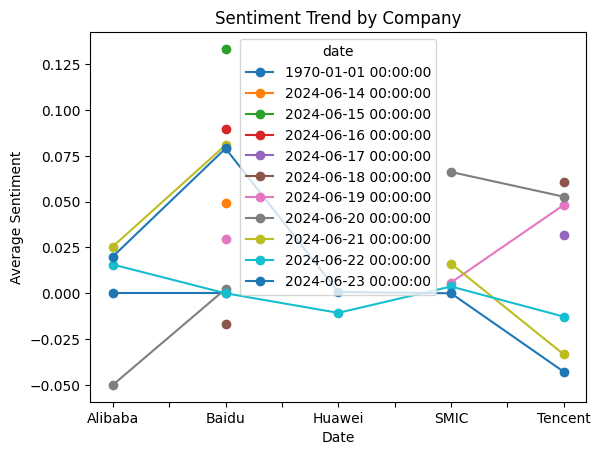

In [ ]:
# @title Sentiment Trend by Company

import matplotlib.pyplot as plt

# Group the data by company and date, and calculate the mean sentiment
sentiment_trend = sentiment_avg_df.groupby(['company', 'date'])['textblob_sentiment'].mean().unstack()

# Plot the sentiment trend for each company
sentiment_trend.plot(kind='line', marker='o')

# Set the title and labels
plt.title('Sentiment Trend by Company')
plt.xlabel('Date')
_ = plt.ylabel('Average Sentiment')


<ipython-input-25-197ab4a89425>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(sentiment_avg_df, x='textblob_sentiment', y='company', inner='stick', palette='Dark2')


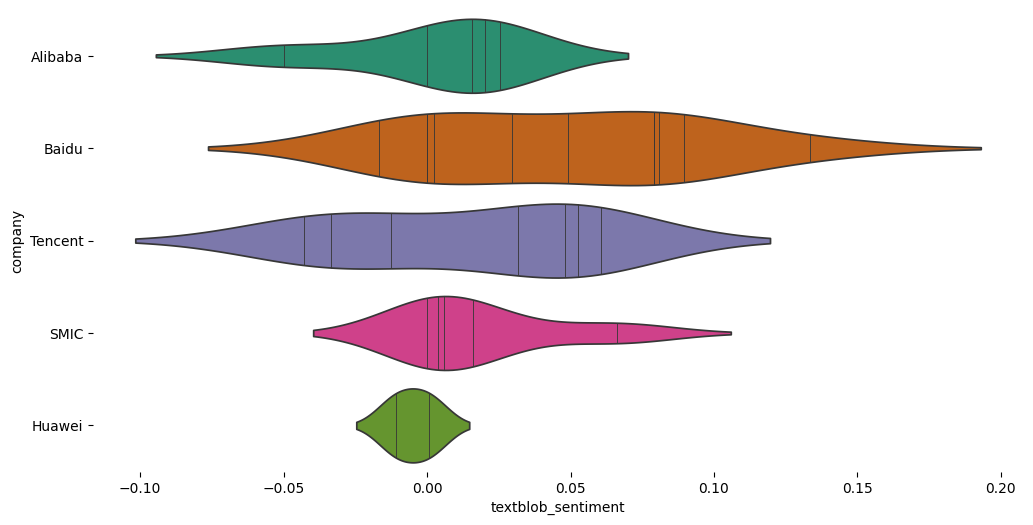

In [ ]:
# @title company vs textblob_sentiment

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(sentiment_avg_df['company'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(sentiment_avg_df, x='textblob_sentiment', y='company', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)